In [1]:
from Literal import Literal
from Rule import Rule
from Argument import Argument

import matplotlib.pyplot as plt
import networkx as nx
import re

Déclaration et affichage des règles de base :

In [146]:
rules = []
rules.append(Rule([], Literal("a", False), False, -1, Literal("r1", False)))
rules.append(Rule([Literal("b", False), Literal("d", False)], Literal("c", False), False, -1, Literal("r2", False)))
rules.append(Rule([Literal("c", True)], Literal("d", False), False, -1, Literal("r3", False)))
rules.append(Rule([Literal("a", False)], Literal("d", True), True, 0, Literal("r4", False)))
rules.append(Rule([], Literal("b", False), True, 1, Literal("r5", False)))
rules.append(Rule([], Literal("c", True), True, 1, Literal("r6", False)))
rules.append(Rule([], Literal("d", False), True, 0, Literal("r7", False)))
rules.append(Rule([Literal("c", False)], Literal("e", False), True, 0, Literal("r8", False)))
rules.append(Rule([Literal("c", True)], Literal("r4", True), True, 0, Literal("r9", False)))

for rule in rules:
    rule.print()

r1 : -> a
r2 : b,d -> c
r3 : ¬c -> d
r4 : a => ¬d 0
r5 : => b 1
r6 : => ¬c 1
r7 : => d 0
r8 : c => e 0
r9 : ¬c => ¬r4 0


Création d'une fonction qui fait la contraposée des règles strictes :

In [147]:
def contraposition(rule):
    new_rules = []
    # If the rule is not defeasible and has premises
    if not rule.get_is_defeasible() and len(rule.get_premises()) > 0:
        # Visit each premise
        for i, _ in enumerate(rule.get_premises()):
            new_premises = list(rule.get_premises())
            new_premises.pop(i)
            new_premises.append(Literal(rule.get_conclusion().get_value(), not rule.get_conclusion().get_is_negative()))
            f = rule.get_reference().get_value() + "c" + str(i + 1)
            new_rule = Rule(new_premises, Literal(rule.get_premises()[i].get_value(), not rule.get_premises()[i].get_is_negative()), False, rule.get_weight(), Literal(f, False))
            new_rules.append(new_rule)
    return new_rules

Affichage des règles et de leur(s) contraposée(s) :

In [148]:
total_rules = list(rules)
for rule in rules:
    new_rules = contraposition(rule)
    for new_rule in new_rules:
        total_rules.append(new_rule)

for rule in total_rules:
    rule.print()
print()

r1 : -> a
r2 : b,d -> c
r3 : ¬c -> d
r4 : a => ¬d 0
r5 : => b 1
r6 : => ¬c 1
r7 : => d 0
r8 : c => e 0
r9 : ¬c => ¬r4 0
r2c1 : d,¬c -> ¬b
r2c2 : b,¬c -> ¬d
r3c1 : ¬d -> c



Fonction qui permer de créer les arguments à partir des règles :

In [149]:
def create_arguments(total_rules):
    arguments = []
    rules = list(total_rules) # list of Rule to be processed
    remaining_rules = list(rules) # list of Rule to be processed
    new_argument_created = True
    
    while (len(remaining_rules) > 0 and new_argument_created):
        new_argument_created = False      
        for i, rule in enumerate(remaining_rules):
            # If the rule has no premises, create a new argument
            if len(rule.get_premises()) == 0:
                name = "A" + str(len(arguments) + 1)
                argument = Argument(rule, [], name)
                arguments.append(argument)
                rules.remove(rule)
                new_argument_created = True
                
        for i, rule in enumerate(remaining_rules):
            # If the rule has premises
                sub_arguments = []
                # Find the sub-arguments which can be used to create a new argument
                for premise in rule.get_premises():
                    for argument in arguments:
                        if argument.get_top_rule().get_conclusion() == premise:
                            sub_arguments.append(argument)
                
                nb_premises = len(rule.get_premises())
                # If the rule has one premise
                if(nb_premises == 1):
                    found = False
                    # Create a new argument if the sub-argument is not found in a argument for the current rule
                    for sub_argument in sub_arguments:
                        for argument in arguments:
                            if argument.get_top_rule() == rule:
                                for sub in argument.get_sub_arguments():
                                    if sub_argument == sub:
                                        found = True
                                        break

                        if not found:
                            name = "A" + str(len(arguments) + 1)
                            argument = Argument(rule,[sub_argument], name)
                            arguments.append(argument)
                            new_argument_created = True
                        found = False
                            
                # If the rule has two premises
                elif(nb_premises == 2):
                    found = False
                    # Create a new argument if the 2 sub-arguments are not found in a same argument for the current rule
                    for i in range(0, len(sub_arguments)):
                        for j in range(0, len(sub_arguments)):
                            if(sub_arguments[i].get_top_rule().get_conclusion() != sub_arguments[j].get_top_rule().get_conclusion()):
                                for argument in arguments:
                                    if argument.get_top_rule() == rule:
                                        for sub in argument.get_sub_arguments():
                                            for sub2 in argument.get_sub_arguments():
                                                if sub != sub2:
                                                    if (sub_arguments[i] == sub and sub_arguments[j] == sub2) or (sub_arguments[i] == sub2 and sub_arguments[j] == sub):
                                                        found = True
                                                        break
                                                        
                                if not found :
                                    name = "A" + str(len(arguments) + 1)
                                    argument = Argument(rule, [sub_arguments[i], sub_arguments[j]], name)
                                    arguments.append(argument)
                                    new_argument_created = True
                                found = False
                        
        remaining_rules = list(rules)
        
    return arguments

Affichage des arguments générés :

In [150]:
arguments = create_arguments(total_rules)
for argument in arguments:
    argument.print()

A1 :  -> a
A2 :  => b
A3 :  => ¬c
A4 :  => d
A5 : A2,A4 -> c
A6 : A3 -> d
A7 : A1 => ¬d
A8 : A5 => e
A9 : A3 => ¬r4
A10 : A4,A3 -> ¬b
A11 : A6,A3 -> ¬b
A12 : A2,A3 -> ¬d
A13 : A7 -> c
A14 : A12 -> c
A15 : A2,A6 -> c
A16 : A13 => e
A17 : A14 => e
A18 : A15 => e


Affichage des arguments avec la liste de leurs règles défaisables, la liste de leurs dernières règles défaisables et la liste de leurs sous-arguments :

In [151]:
for argument in arguments:
    argument.print()
    
    defeasible_rules = argument.get_defeasible_rules()
    print("Defeasible rules of " + argument.get_name() + ":", end=" ")
    for i, rule in enumerate(defeasible_rules):
        print(rule.get_reference().get_value(), end="")
        if i < len(defeasible_rules) - 1:
            print(",", end="")  
    print()   
    
    last_defeasible_rules = argument.get_last_defeasible_rules()
    print("Last defeasible rules of " + argument.get_name() + ":" , end=" ")
    for i, rule in enumerate(last_defeasible_rules):
        print(rule.get_reference().get_value(), end="")
        if i < len(last_defeasible_rules) - 1:
            print(",", end="")
    print()
        
    sub_arguments = argument.get_sub_arguments()
    print("Sub-arguments of " + argument.get_name() + ":" , end=" ")
    for sub_argument in sub_arguments:
        print(sub_argument.get_name(), end="")
        if sub_argument != sub_arguments[-1]:
            print(",", end="")

    print("\n")

A1 :  -> a
Defeasible rules of A1: 
Last defeasible rules of A1: 
Sub-arguments of A1: 

A2 :  => b
Defeasible rules of A2: r5
Last defeasible rules of A2: r5
Sub-arguments of A2: 

A3 :  => ¬c
Defeasible rules of A3: r6
Last defeasible rules of A3: r6
Sub-arguments of A3: 

A4 :  => d
Defeasible rules of A4: r7
Last defeasible rules of A4: r7
Sub-arguments of A4: 

A5 : A2,A4 -> c
Defeasible rules of A5: r5,r7
Last defeasible rules of A5: r5,r7
Sub-arguments of A5: A2,A4

A6 : A3 -> d
Defeasible rules of A6: r6
Last defeasible rules of A6: r6
Sub-arguments of A6: A3

A7 : A1 => ¬d
Defeasible rules of A7: r4
Last defeasible rules of A7: r4
Sub-arguments of A7: A1

A8 : A5 => e
Defeasible rules of A8: r8,r5,r7
Last defeasible rules of A8: r8
Sub-arguments of A8: A5

A9 : A3 => ¬r4
Defeasible rules of A9: r9,r6
Last defeasible rules of A9: r9
Sub-arguments of A9: A3

A10 : A4,A3 -> ¬b
Defeasible rules of A10: r7,r6
Last defeasible rules of A10: r7,r6
Sub-arguments of A10: A4,A3

A11 : A6

Fonction qui permet de générer les undercuts par rapport aux arguments :

In [152]:
def generate_undercuts(arguments):
    attackers = []
    undercuts = []
    
    for argument in arguments:
        conclusion = argument.get_top_rule().get_conclusion()
        # Check if the conclusion is the negation of a rule
        if "r" in conclusion.get_value() and conclusion.get_is_negative():
            attackers.append(argument)

    for attacker in attackers:
        for argument in arguments:
            # Check if the attacker's conclusion is the argument's top rule's 
            if argument.get_top_rule().get_reference().get_value() == attacker.get_top_rule().get_conclusion().get_value():
                undercuts.append([attacker.get_name(), argument.get_name()])
            else :
                # Find if a sub-argument be part of the attacked arguments
                for sub_argument in argument.get_sub_arguments():
                    for i, _ in enumerate(undercuts):
                        # Chek if the sub-argument is already in the undercuts list
                        if undercuts[i][0] == attacker.get_name() and undercuts[i][1] == sub_argument.get_name():
                            undercuts.append([attacker.get_name(), argument.get_name()])
                            break
          
    # Print the undercuts
    for i, _ in enumerate(undercuts):
        print("(" + undercuts[i][0] + "," + undercuts[i][1] + ")" , end=" ")
        
    print("\n")
        
    return undercuts

Affichage des undercuts générés :

In [153]:
undercuts = generate_undercuts(arguments)

(A9,A7) (A9,A13) (A9,A16) 



Fonction qui permet de générer les rebuts par rapport aux arguments :

In [154]:
def generate_rebuts(arguments):
    rebuts = []
    
    for argument in arguments:
        for argument2 in arguments:
            #Check if the argument's conclusion is the negation of the argument2's conclusion
            if (argument.get_top_rule().get_conclusion().get_value() == argument2.get_top_rule().get_conclusion().get_value() and 
            argument.get_top_rule().get_conclusion().get_is_negative() != argument2.get_top_rule().get_conclusion().get_is_negative()):
                rebuts.append([argument.get_name(), argument2.get_name()])
            else :
                # Find if a sub-argument of argument2 be part of the attacked arguments
                for sub_argument in argument2.get_sub_arguments():
                    for i, _ in enumerate(rebuts):
                        # Check if the sub-argument is already attacked by the argument 
                        if rebuts[i][0] == argument.get_name() and rebuts[i][1] == sub_argument.get_name():
                            # Check duplicates
                            if [argument.get_name(), argument2.get_name()] not in rebuts:
                                rebuts.append([argument.get_name(), argument2.get_name()])
                                break
                        
    # Print the rebuts
    attacker = 1
    print("Number of rebuts: " + str(len(rebuts)))
    for i, _ in enumerate(rebuts):
        number = rebuts[i][0][1:]
        if int(number) > attacker:
            attacker = int(number)
            print()
        print("(" + rebuts[i][0] + "," + rebuts[i][1] + ")" , end=" ")
    print("\n")
        
    return rebuts

Affichage des rebuts générés :

In [155]:
rebuts = generate_rebuts(arguments)

Number of rebuts: 94

(A2,A10) (A2,A11) 
(A3,A5) (A3,A8) (A3,A13) (A3,A14) (A3,A15) (A3,A16) (A3,A17) (A3,A18) 
(A4,A7) (A4,A12) (A4,A13) (A4,A14) (A4,A16) (A4,A17) 
(A5,A3) (A5,A6) (A5,A9) (A5,A10) (A5,A11) (A5,A12) (A5,A14) (A5,A15) (A5,A17) (A5,A18) 
(A6,A7) (A6,A12) (A6,A13) (A6,A14) (A6,A16) (A6,A17) 
(A7,A4) (A7,A5) (A7,A6) (A7,A8) (A7,A10) (A7,A11) (A7,A15) (A7,A18) 
(A10,A2) (A10,A5) (A10,A8) (A10,A12) (A10,A14) (A10,A15) (A10,A17) (A10,A18) 
(A11,A2) (A11,A5) (A11,A8) (A11,A12) (A11,A14) (A11,A15) (A11,A17) (A11,A18) 
(A12,A4) (A12,A5) (A12,A6) (A12,A8) (A12,A10) (A12,A11) (A12,A15) (A12,A18) 
(A13,A3) (A13,A6) (A13,A9) (A13,A10) (A13,A11) (A13,A12) (A13,A14) (A13,A15) (A13,A17) (A13,A18) 
(A14,A3) (A14,A6) (A14,A9) (A14,A10) (A14,A11) (A14,A12) (A14,A14) (A14,A15) (A14,A17) (A14,A18) 
(A15,A3) (A15,A6) (A15,A9) (A15,A10) (A15,A11) (A15,A12) (A15,A14) (A15,A15) (A15,A17) (A15,A18) 



Représentation des préférences entre les règles :

In [156]:
preferred_rules = {}
for rule in total_rules:
    if rule.get_weight() == -1:
        preferred_rules[rule.get_reference().get_value()] = 1
    elif rule.get_weight() == 0:
        preferred_rules[rule.get_reference().get_value()] = 3
    elif rule.get_weight() == 1:
        preferred_rules[rule.get_reference().get_value()] = 2 
    
for rule in preferred_rules:
    print(rule + ":", preferred_rules[rule])

r1: 1
r2: 1
r3: 1
r4: 3
r5: 2
r6: 2
r7: 3
r8: 3
r9: 3
r2c1: 1
r2c2: 1
r3c1: 1


Création d'une fonction qui permet de comparer les arguments entre eux :

In [157]:
def compareArguments(arguments,preferred_rules,principle,link_principle):
    preferred_arguments = {}
    priorityArgument = 0
           
    for argument in arguments:
        # Place the arguments without defeasible rule in the preferred arguments 
        if argument.get_defeasible_rules() == []:
            preferred_arguments[argument.get_name()] = 1
        
        # Place the arguments with defeasible rules in the preferred arguments
        else:
            match link_principle:
                # In the case of the Weakest Link principle, we get the defeasible rules of the argument
                case "Weakest Link":
                    defeasible_rules = argument.get_defeasible_rules()
                    match principle:
                        # In the case of the Elitist principle, the argument take the priority of the best rule
                        case "Elitist":
                            priorityArgument = 99999    
                            for rule in defeasible_rules:
                                priorityRule = preferred_rules[rule.get_reference().get_value()]
                                if priorityRule < priorityArgument:
                                    priorityArgument = priorityRule
                        # In the case of the Democratic principle, the argument take the priority of the worst rule
                        case "Democratic":
                            priorityArgument = 0
                            for rule in defeasible_rules:
                                priorityRule = preferred_rules[rule.get_reference().get_value()]
                                if priorityRule > priorityArgument:
                                    priorityArgument = priorityRule
                    
                # In the case of the Last Link principle, we get the last defeasible rules of the argument
                case "Last Link":
                    last_defeasible_rules = argument.get_last_defeasible_rules()
                    match preferred_arguments:
                        # In the case of the Elitist principle, the argument take the priority of the best rule
                        case "Elitist":
                            priorityArgument = 99999
                            for rule in last_defeasible_rules:
                                priorityRule = preferred_rules[rule.get_reference().get_value()]
                                if priorityRule < priorityArgument:
                                    priorityArgument = priorityRule
                        # In the case of the Democratic principle, the argument take the priority of the worst rule
                        case "Democratic":
                            priorityArgument = 0
                            for rule in last_defeasible_rules:
                                priorityRule = preferred_rules[rule.get_reference().get_value()]
                                if priorityRule > priorityArgument:
                                    priorityArgument = priorityRule
                                    
            preferred_arguments[argument.get_name()] = priorityArgument
        
    # Print in order of priority
    max_priority = 0
    for argument in preferred_arguments:
        if preferred_arguments[argument] > max_priority:
            max_priority = preferred_arguments[argument]
            
    for i in range(1,max_priority + 1):
        for argument in preferred_arguments:
            if preferred_arguments[argument] == i:
                print(argument, end=" ")
        if i < max_priority:
            print("<", end=" ")
    print("\n")
        
    return preferred_arguments

Representation des préférences entre les arguments :

In [158]:
preferred_arguments = compareArguments(arguments,preferred_rules,"Democratic","Weakest Link")

A1 < A2 A3 A6 A11 A12 A14 A15 < A4 A5 A7 A8 A9 A10 A13 A16 A17 A18 



Fonction permettant de générer les défaites :

In [159]:
def generate_defeats(arguments, rebuts, preferred_arguments):
    defeats = []
    for rebut in rebuts:
        # Check if the attacker is in the preferred arguments
        if preferred_arguments[rebut[0]] <= preferred_arguments[rebut[1]]:
            defeats.append(rebut)
        else:
            # Check if the attacker argument has aleady a defeat in a sub-argument of the attacked argument
            for argument in arguments:
                if argument.get_name() == rebut[1]:
                    for sub_argument in argument.get_sub_arguments():
                        for defeat in defeats:
                            if defeat[0] == rebut[0] and defeat[1] == sub_argument.get_name():
                                defeats.append(rebut)
                                break
                    
    # Print the defeats
    attacker = 1
    print("Number of defeats: " + str(len(defeats)))
    for i, _ in enumerate(defeats):
        number = defeats[i][0][1:]
        if int(number) > attacker:
            attacker = int(number)
            print()
        print("(" + defeats[i][0] + "," + defeats[i][1] + ")" , end=" ")
    print("\n")
    
    return defeats

Représentation des préférences entre les arguments :

In [160]:
defeats = generate_defeats(arguments, rebuts, preferred_arguments)

Number of defeats: 73

(A2,A10) (A2,A11) 
(A3,A5) (A3,A8) (A3,A13) (A3,A14) (A3,A15) (A3,A16) (A3,A17) (A3,A18) 
(A4,A7) (A4,A13) (A4,A16) (A4,A17) 
(A5,A9) (A5,A10) (A5,A17) (A5,A18) 
(A6,A7) (A6,A12) (A6,A13) (A6,A14) (A6,A16) (A6,A17) 
(A7,A4) (A7,A5) (A7,A8) (A7,A10) (A7,A18) 
(A10,A5) (A10,A8) (A10,A17) (A10,A18) 
(A11,A2) (A11,A5) (A11,A8) (A11,A12) (A11,A14) (A11,A15) (A11,A17) (A11,A18) 
(A12,A4) (A12,A5) (A12,A6) (A12,A8) (A12,A10) (A12,A11) (A12,A15) (A12,A18) 
(A13,A9) (A13,A10) (A13,A17) (A13,A18) 
(A14,A3) (A14,A6) (A14,A9) (A14,A10) (A14,A11) (A14,A12) (A14,A14) (A14,A15) (A14,A17) (A14,A18) 
(A15,A3) (A15,A6) (A15,A9) (A15,A10) (A15,A11) (A15,A12) (A15,A14) (A15,A15) (A15,A17) (A15,A18) 



Génération d'un graphe d'attaque :

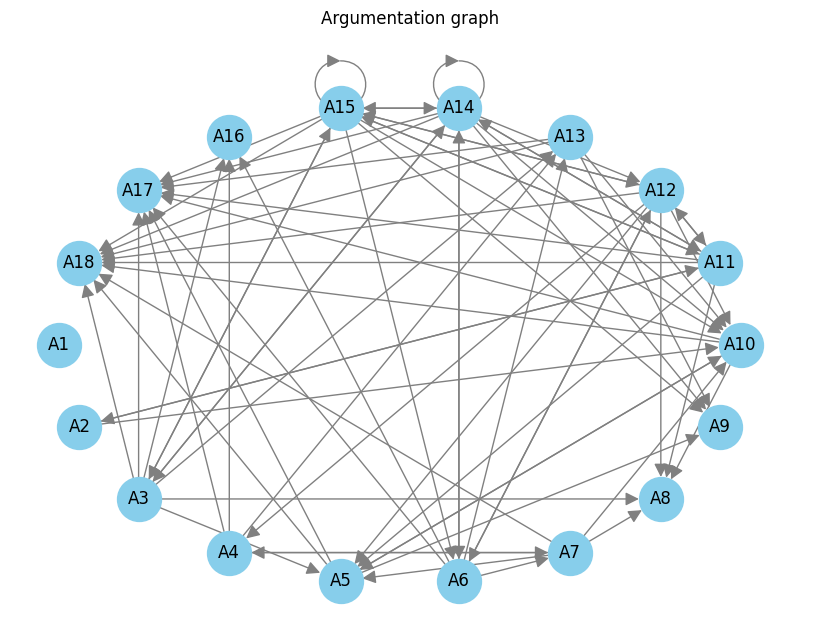

In [161]:
G = nx.DiGraph()

# Add the nodes (arguments)
argument_names = []
for argument in arguments:
    argument_names.append(argument.get_name())
G.add_nodes_from(argument_names)

# Add the edges (attacks)
G.add_edges_from(defeats)

# Visualisation du graphe
plt.figure(figsize=(8, 6))
pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', font_size=12, arrowsize=20, linewidths=1, edge_color='gray', arrows=True)

plt.title("Argumentation graph")
plt.show()